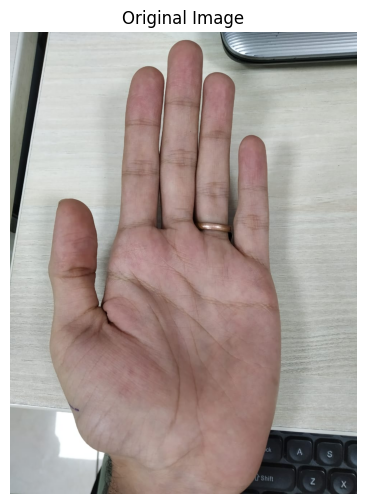

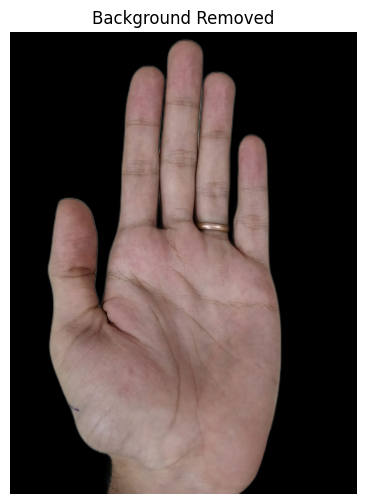

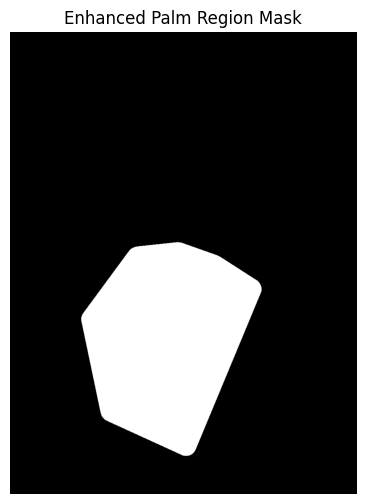

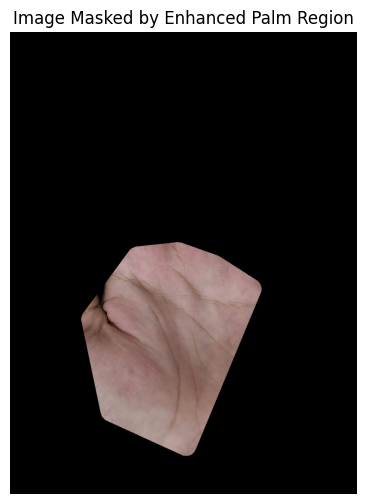

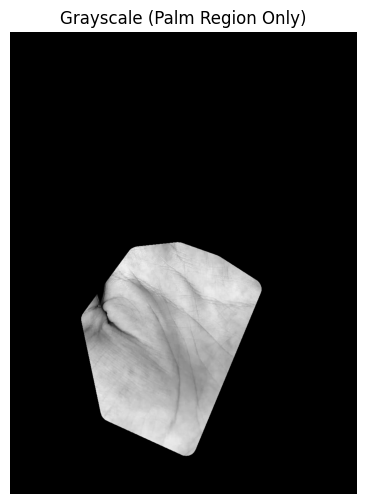

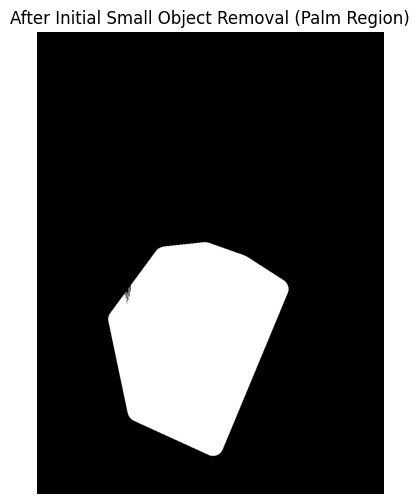

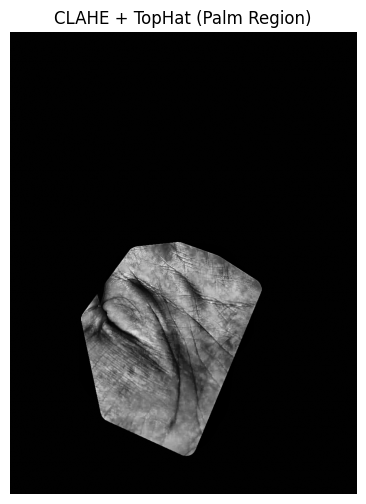

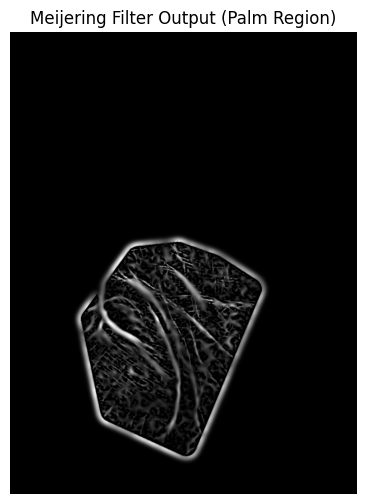

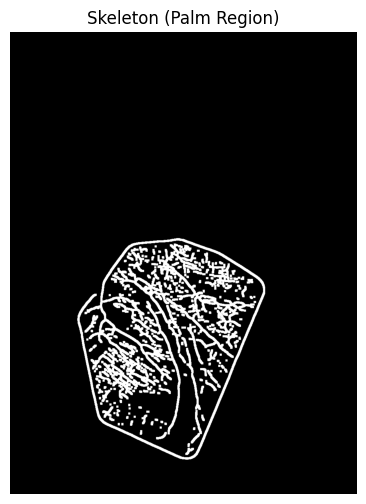

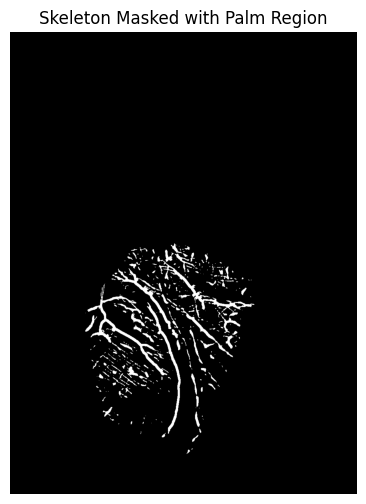

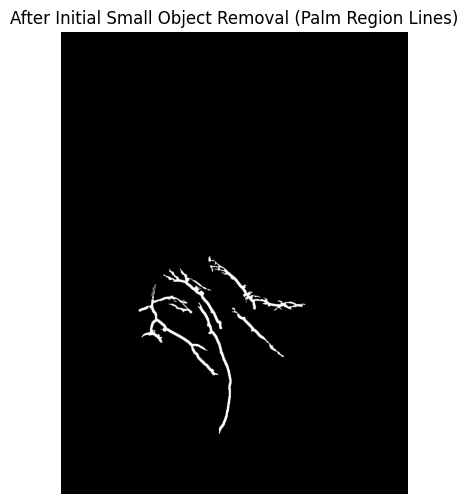

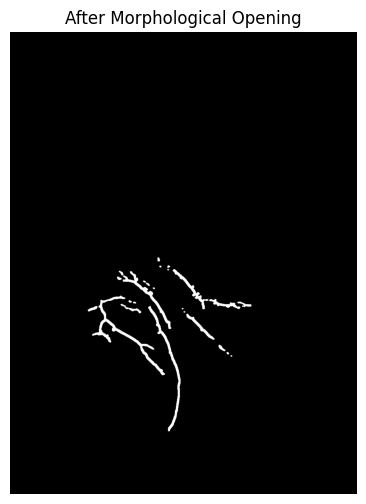

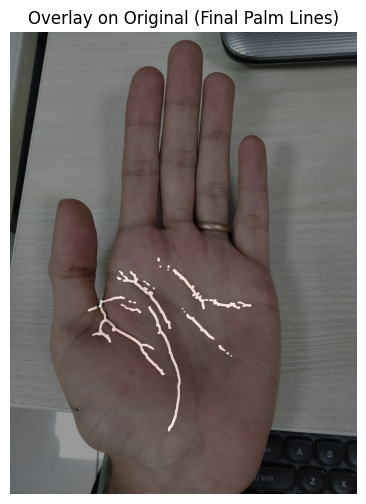

In [5]:
import cv2
import numpy as np
import mediapipe as mp
from skimage.morphology import skeletonize, remove_small_objects
from skimage.filters import meijering
from skimage.util import img_as_ubyte
import matplotlib.pyplot as plt
from rembg import remove
import io
from PIL import Image
import os

# Convert OpenCV image to PNG bytes
def cv2_to_bytes(image):
    success, encoded_image = cv2.imencode('.png', image)
    return io.BytesIO(encoded_image.tobytes()) if success else None

# Background remover using rembg
def remove_background_opencv(img):
    image_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    pil_image = Image.fromarray(image_rgb)
    byte_io = io.BytesIO()
    pil_image.save(byte_io, format="PNG")
    byte_io.seek(0)
    result_bytes = remove(byte_io.read())
    no_bg_image = Image.open(io.BytesIO(result_bytes)).convert("RGB")
    return cv2.cvtColor(np.array(no_bg_image), cv2.COLOR_RGB2BGR)

def show_image(title, image, cmap='gray'):
    plt.figure(figsize=(6, 6))
    plt.title(title)
    if len(image.shape) == 2:
        plt.imshow(image, cmap=cmap)
    else:
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()
    cv2.imwrite(f"./saved/{title}.png", image)  # Save the image for reference

image_path = "./image.png"
img = cv2.imread(image_path)

if img is None:
    raise FileNotFoundError(f"Image not found at: {image_path}")
    
original = img.copy()
show_image("Original Image", original, cmap=None)

img_no_bg = remove_background_opencv(img.copy())
show_image("Background Removed", img_no_bg, cmap=None)

mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=1, min_detection_confidence=0.5)

image_rgb = cv2.cvtColor(img_no_bg, cv2.COLOR_BGR2RGB)
results = hands.process(image_rgb)

palm_mask = np.ones(img_no_bg.shape[:2], dtype=np.uint8) * 255 

if results.multi_hand_landmarks:
    for hand_landmarks in results.multi_hand_landmarks:
        h, w, _ = img_no_bg.shape

        # === Get base palm landmarks ===
        palm_indices = [0, 1, 2, 5, 9, 13, 17]
        palm_points = []
        for idx in palm_indices:
            lm = hand_landmarks.landmark[idx]
            x, y = int(lm.x * w), int(lm.y * h)
            palm_points.append([x, y])
        palm_points = np.array(palm_points, dtype=np.int32)

        # === Fill convex palm mask ===
        palm_mask = np.zeros((h, w), dtype=np.uint8)
        palm_hull = cv2.convexHull(palm_points)
        cv2.fillConvexPoly(palm_mask, palm_hull, 255)

        # === Remove fingers ===
        finger_groups = [
            [1, 2, 3, 4],      # Thumb
            [5, 6, 7, 8],      # Index
            [9, 10, 11, 12],   # Middle
            [13, 14, 15, 16],  # Ring
            [17, 18, 19, 20]   # Pinky
        ]
        for group in finger_groups:
            finger_pts = []
            for idx in group:
                lm = hand_landmarks.landmark[idx]
                x, y = int(lm.x * w), int(lm.y * h)
                finger_pts.append([x, y])
            finger_pts = np.array(finger_pts, dtype=np.int32)
            cv2.fillConvexPoly(palm_mask, finger_pts, 0)  # Erase finger area

        # === Dilate mask to restore palm volume ===
        dilation_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (55, 55))
        palm_mask = cv2.dilate(palm_mask, dilation_kernel, iterations=1)




hands.close()
show_image("Enhanced Palm Region Mask", palm_mask)

# Apply the palm mask early in the process to remove finger areas
img_masked = cv2.bitwise_and(img_no_bg, img_no_bg, mask=palm_mask)
show_image("Image Masked by Enhanced Palm Region", img_masked, cmap=None)

# 3. Negative filter + grayscale (from masked image)
gray = cv2.cvtColor(img_masked, cv2.COLOR_BGR2GRAY)
show_image("Grayscale (Palm Region Only)", gray)

# 4. Remove small noise (initial) - apply to the palm-masked gray image
cleaned = remove_small_objects(gray.astype(bool), min_size=50, connectivity=2)
cleaned = (cleaned * 255).astype(np.uint8)
outerline = cleaned.copy() 
show_image("After Initial Small Object Removal (Palm Region)", cleaned)

# 6. CLAHE + TopHat
clahe = cv2.createCLAHE(clipLimit=5.0, tileGridSize=(10, 10))
enhanced = clahe.apply(gray) 
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 14))
tophat = cv2.morphologyEx(enhanced, cv2.MORPH_TOPHAT, kernel)
combined = cv2.addWeighted(enhanced, 0.8, tophat, 0.8, 0)
show_image("CLAHE + TopHat (Palm Region)", combined)

# 7. Meijering line enhancement
meij = meijering(combined / 255.0, sigmas=range(2, 8), black_ridges=True)
meij = img_as_ubyte(meij)
show_image("Meijering Filter Output (Palm Region)", meij)

# 8. Threshold + Skeleton
_, binary = cv2.threshold(meij, 50, 255, cv2.THRESH_BINARY)
skeleton = skeletonize(binary // 255).astype(np.uint8) * 255
kernel_thick = cv2.getStructuringElement(cv2.MORPH_RECT, (6, 6))
skeleton = cv2.dilate(skeleton, kernel_thick, iterations=1)

show_image("Skeleton (Palm Region)", skeleton)

# 9. Apply mask again (now outerline is the palm region)
_, binary_mask = cv2.threshold(meij, 60, 255, cv2.THRESH_BINARY)
skeleton = cv2.bitwise_and(skeleton, skeleton, mask=outerline) 
skeleton = cv2.bitwise_and(skeleton, skeleton, mask=binary_mask)
show_image("Skeleton Masked with Palm Region", skeleton)

# 10. Remove small objects after skeleton (adjust min_size if needed)
cleaned_final_lines = remove_small_objects(skeleton.astype(bool), min_size=600, connectivity=1)
cleaned_final_lines = (cleaned_final_lines * 255).astype(np.uint8)
show_image("After Initial Small Object Removal (Palm Region Lines)", cleaned_final_lines)

# --- STEPS TO FURTHER REMOVE FINGER LINES (from previous iteration) ---

# 11. Aggressive Morphological Opening
kernel_opening = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5)) 
cleaned_final_lines = cv2.morphologyEx(cleaned_final_lines, cv2.MORPH_OPEN, kernel_opening, iterations=1) 
show_image("After Morphological Opening", cleaned_final_lines)



# 14. Overlay result on original
result_img = cv2.cvtColor(cleaned_final_lines, cv2.COLOR_GRAY2BGR)
overlay = cv2.addWeighted(original, 0.6, result_img, 0.6, 0)
show_image("Overlay on Original (Final Palm Lines)", overlay, cmap=None)

In [1]:
import cv2
import numpy as np

if results.multi_hand_landmarks:
    for hand_landmarks in results.multi_hand_landmarks:
        h, w, _ = img_no_bg.shape

        # Get key points
        pt1 = hand_landmarks.landmark[1]   # THUMB_CMC
        pt2 = hand_landmarks.landmark[5]   # INDEX_MCP
        pt3 = hand_landmarks.landmark[17]  # PINKY_MCP

        # Convert to pixel coordinates
        p1 = np.array([int(pt1.x * w), int(pt1.y * h)])
        p2 = np.array([int(pt2.x * w), int(pt2.y * h)])
        p3 = np.array([int(pt3.x * w), int(pt3.y * h)])

        # Direction vectors
        v_horizontal = (p3 - p2).astype(np.float32)
        v_vertical = (p1 - p2).astype(np.float32)

        # Scale vectors (1.4 means 40% larger)
        scale_factor = 1.4
        v_h_scaled = v_horizontal * scale_factor
        v_v_scaled = v_vertical * scale_factor

        # Recompute rectangle corners
        p2_new = p2 - v_h_scaled * 0.2  # shift left
        p3_new = p2_new + v_h_scaled    # shift right
        p1_new = p2 - v_v_scaled * 0.2  # shift upward
        p4_new = p1_new + v_h_scaled    # opposite corner

        # Final rectangle points
        rect_pts = np.array([
            p1_new, p2_new, p3_new, p4_new
        ], dtype=np.int32).reshape((-1, 1, 2))

        # Draw enlarged rectangle
        cv2.polylines(img_no_bg, [rect_pts], isClosed=True, color=(0, 255, 0), thickness=2)

        # Optional: crop enlarged area
        x, y, w_box, h_box = cv2.boundingRect(rect_pts)
        enlarged_crop = img_no_bg[y:y+h_box, x:x+w_box]

        # Show output
        cv2.imshow("Palm + Enlarged Rect", img_no_bg)
        cv2.imshow("Enlarged Palm Crop", enlarged_crop)
        cv2.waitKey(0)


NameError: name 'results' is not defined

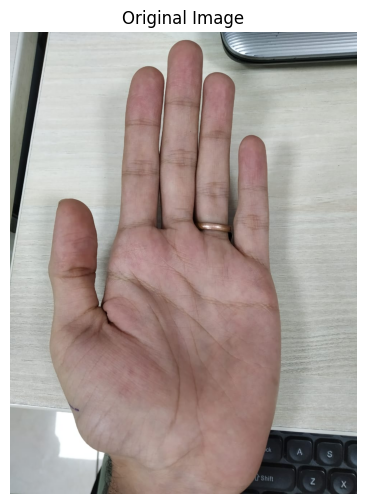

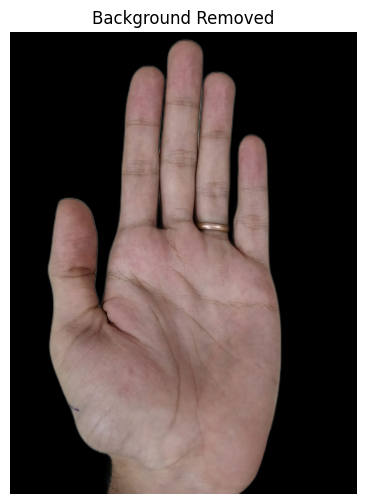

✅ Palm detected by model. Cropping saved.


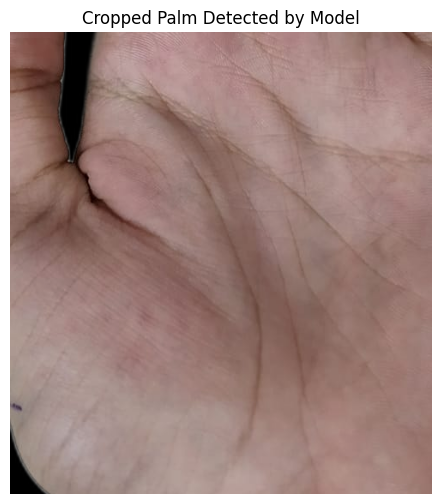

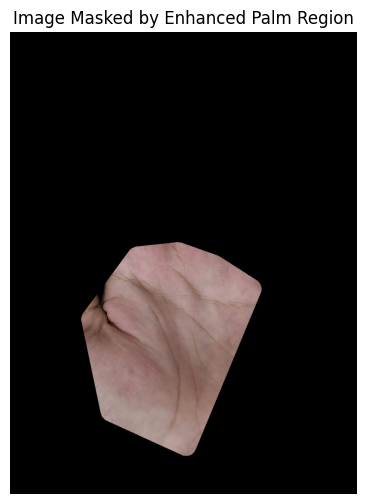

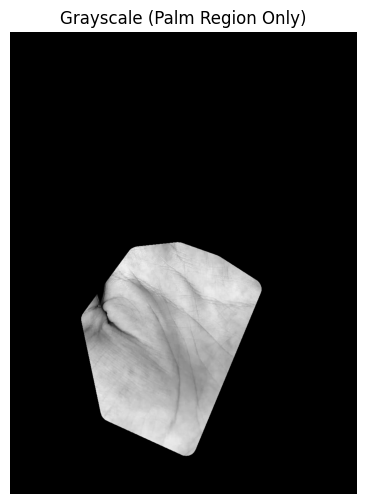

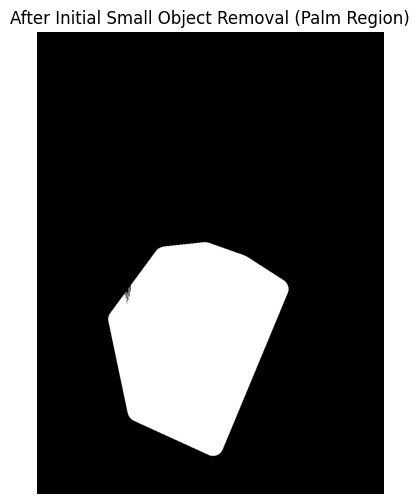

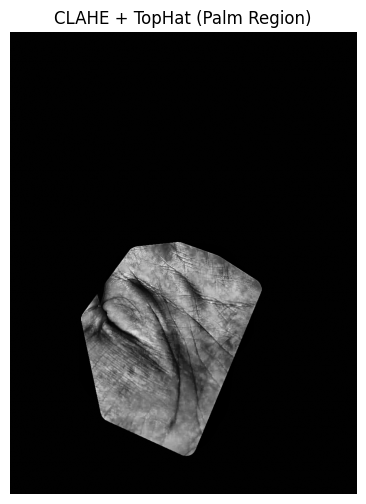

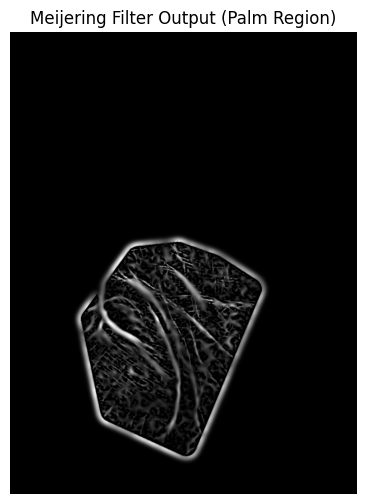

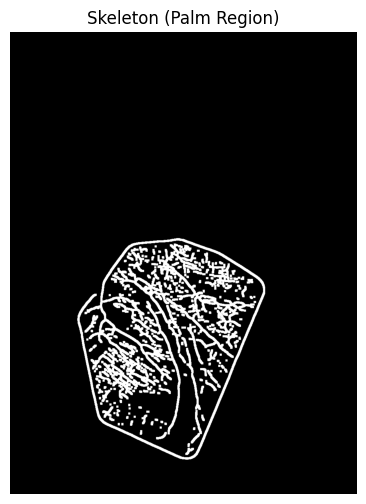

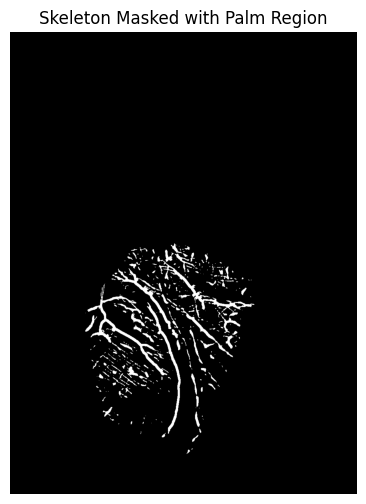

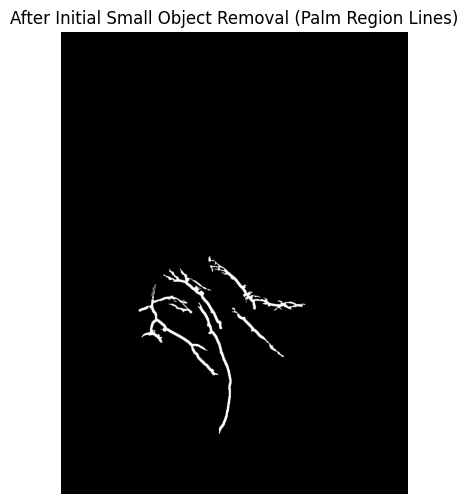

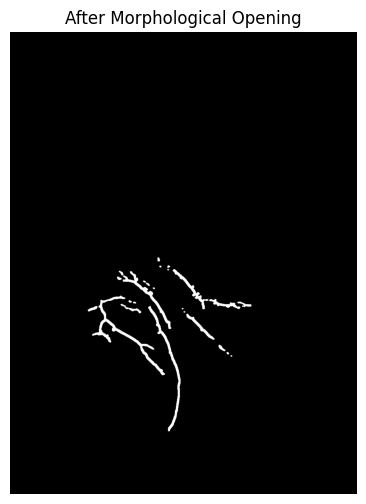

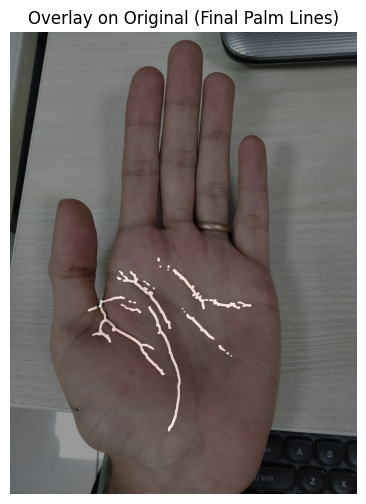

In [8]:
import cv2
import numpy as np
import mediapipe as mp
from skimage.morphology import skeletonize, remove_small_objects
from skimage.filters import meijering
from skimage.util import img_as_ubyte
import matplotlib.pyplot as plt
from rembg import remove
import io
from PIL import Image
import os
from tensorflow.keras.models import load_model

# === Load palm detection model ===
model = load_model("./palm_detection.h5")  # Adjust path if needed

def is_palm(image):
    try:
        resized = cv2.resize(image, (224, 224))
        normalized = resized.astype('float32') / 255.0
        input_tensor = np.expand_dims(normalized, axis=0)
        prediction = model.predict(input_tensor, verbose=0)[0][0]
        return prediction > 0.5
    except Exception as e:
        print("Prediction failed:", e)
        return False

def cv2_to_bytes(image):
    success, encoded_image = cv2.imencode('.png', image)
    return io.BytesIO(encoded_image.tobytes()) if success else None

def remove_background_opencv(img):
    image_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    pil_image = Image.fromarray(image_rgb)
    byte_io = io.BytesIO()
    pil_image.save(byte_io, format="PNG")
    byte_io.seek(0)
    result_bytes = remove(byte_io.read())
    no_bg_image = Image.open(io.BytesIO(result_bytes)).convert("RGB")
    return cv2.cvtColor(np.array(no_bg_image), cv2.COLOR_RGB2BGR)

def show_image(title, image, cmap='gray'):
    plt.figure(figsize=(6, 6))
    plt.title(title)
    if len(image.shape) == 2:
        plt.imshow(image, cmap=cmap)
    else:
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()
    cv2.imwrite(f"./saved/{title}.png", image)

# === Load and process image ===
image_path = "./image.png"
img = cv2.imread(image_path)
if img is None:
    raise FileNotFoundError(f"Image not found at: {image_path}")

original = img.copy()
show_image("Original Image", original, cmap=None)

# === Remove background ===
img_no_bg = remove_background_opencv(img.copy())
show_image("Background Removed", img_no_bg, cmap=None)

# === Detect palm using MediaPipe ===
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=1, min_detection_confidence=0.5)
image_rgb = cv2.cvtColor(img_no_bg, cv2.COLOR_BGR2RGB)
results = hands.process(image_rgb)

palm_mask = np.ones(img_no_bg.shape[:2], dtype=np.uint8) * 255
cropped_palm = None

if results.multi_hand_landmarks:
    for hand_landmarks in results.multi_hand_landmarks:
        h, w, _ = img_no_bg.shape

        palm_indices = [0, 1, 2, 5, 9, 13, 17]
        palm_points = []
        for idx in palm_indices:
            lm = hand_landmarks.landmark[idx]
            x, y = int(lm.x * w), int(lm.y * h)
            palm_points.append([x, y])
        palm_points = np.array(palm_points, dtype=np.int32)

        palm_mask = np.zeros((h, w), dtype=np.uint8)
        palm_hull = cv2.convexHull(palm_points)
        cv2.fillConvexPoly(palm_mask, palm_hull, 255)

        finger_groups = [
            [1, 2, 3, 4],
            [5, 6, 7, 8],
            [9, 10, 11, 12],
            [13, 14, 15, 16],
            [17, 18, 19, 20]
        ]
        for group in finger_groups:
            finger_pts = []
            for idx in group:
                lm = hand_landmarks.landmark[idx]
                x, y = int(lm.x * w), int(lm.y * h)
                finger_pts.append([x, y])
            finger_pts = np.array(finger_pts, dtype=np.int32)
            cv2.fillConvexPoly(palm_mask, finger_pts, 0)

        dilation_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (55, 55))
        palm_mask = cv2.dilate(palm_mask, dilation_kernel, iterations=1)

        # Crop based on bounding box
        x, y, w_box, h_box = cv2.boundingRect(palm_hull)
        palm_crop = img_no_bg[y:y+h_box, x:x+w_box]

        if palm_crop.shape[0] > 10 and palm_crop.shape[1] > 10:
            if is_palm(palm_crop):
                print("✅ Palm detected by model. Cropping saved.")
                cropped_palm = palm_crop
                show_image("Cropped Palm Detected by Model", palm_crop)
            else:
                print("❌ Palm region rejected by model.")

hands.close()

# === Proceed with line extraction only if palm was detected ===
if cropped_palm is not None:
    img_masked = cv2.bitwise_and(img_no_bg, img_no_bg, mask=palm_mask)
    show_image("Image Masked by Enhanced Palm Region", img_masked)

    gray = cv2.cvtColor(img_masked, cv2.COLOR_BGR2GRAY)
    show_image("Grayscale (Palm Region Only)", gray)

    cleaned = remove_small_objects(gray.astype(bool), min_size=50, connectivity=2)
    cleaned = (cleaned * 255).astype(np.uint8)
    outerline = cleaned.copy() 
    show_image("After Initial Small Object Removal (Palm Region)", cleaned)

    clahe = cv2.createCLAHE(clipLimit=5.0, tileGridSize=(10, 10))
    enhanced = clahe.apply(gray) 
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 14))
    tophat = cv2.morphologyEx(enhanced, cv2.MORPH_TOPHAT, kernel)
    combined = cv2.addWeighted(enhanced, 0.8, tophat, 0.8, 0)
    show_image("CLAHE + TopHat (Palm Region)", combined)

    meij = meijering(combined / 255.0, sigmas=range(2, 8), black_ridges=True)
    meij = img_as_ubyte(meij)
    show_image("Meijering Filter Output (Palm Region)", meij)

    _, binary = cv2.threshold(meij, 50, 255, cv2.THRESH_BINARY)
    skeleton = skeletonize(binary // 255).astype(np.uint8) * 255
    kernel_thick = cv2.getStructuringElement(cv2.MORPH_RECT, (6, 6))
    skeleton = cv2.dilate(skeleton, kernel_thick, iterations=1)
    show_image("Skeleton (Palm Region)", skeleton)

    _, binary_mask = cv2.threshold(meij, 60, 255, cv2.THRESH_BINARY)
    skeleton = cv2.bitwise_and(skeleton, skeleton, mask=outerline) 
    skeleton = cv2.bitwise_and(skeleton, skeleton, mask=binary_mask)
    show_image("Skeleton Masked with Palm Region", skeleton)

    cleaned_final_lines = remove_small_objects(skeleton.astype(bool), min_size=600, connectivity=1)
    cleaned_final_lines = (cleaned_final_lines * 255).astype(np.uint8)
    show_image("After Initial Small Object Removal (Palm Region Lines)", cleaned_final_lines)

    kernel_opening = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5)) 
    cleaned_final_lines = cv2.morphologyEx(cleaned_final_lines, cv2.MORPH_OPEN, kernel_opening, iterations=1) 
    show_image("After Morphological Opening", cleaned_final_lines)

    result_img = cv2.cvtColor(cleaned_final_lines, cv2.COLOR_GRAY2BGR)
    overlay = cv2.addWeighted(original, 0.6, result_img, 0.6, 0)
    show_image("Overlay on Original (Final Palm Lines)", overlay)
else:
    print("❌ Skipping line detection — palm not detected.")
